# Energy Usage

## Motivation
Towards the end of 2019 I had two Nest thermostats installed in my house and would like to know if it reduces my energy usage over the winter. I've taken my gas readings from the before and after the installation and want to get an idea of whether it affected my usage.

Nest was installed on 21/11/19

In [1]:
import pandas as pd

Let's start by reading in a CSV of the readings and seeing what information we can glean.

In [2]:
dtypes = {'Date':'str', 'Gas Usage (Units)':'int64'}
gas_df = pd.read_csv('data/Energy Usage - Gas.csv', dtype = dtypes, parse_dates=['Date'], dayfirst=True)

In [3]:
gas_df.set_index('Date', inplace=True)

In [4]:
gas_df.head(20)

,Gas Usage (Units)
Date,
2018-10-22,2404
2018-11-04,2427
2018-12-21,2524
2019-01-25,2602
2019-03-01,2675
2019-04-24,2764
2019-07-17,2804
2019-08-03,2812
2019-08-25,2822


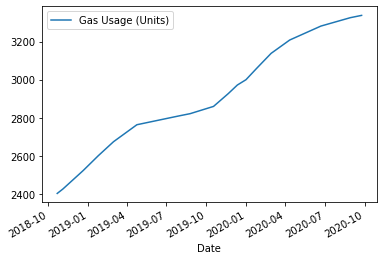

In [5]:
%matplotlib inline
gas_df.plot()

A quick glance at the data shows that the readings aren't taken at evenly spaced intervals. Some months are missing whilst some have two readings. It will probably help to interpolate the data to smooth this out. Similarly the graph doesn't tell us much as it is continually increasing, a usage per month would be more useful.

In [6]:
# Add missing dates as index
gas_df_reindexed = gas_df.reindex(pd.date_range(start=gas_df.index.min(),
                                                  end=gas_df.index.max(),
                                                  freq='1D')) 

In [7]:
gas_df_reindexed.head()

,Gas Usage (Units)
2018-10-22,2404.0
2018-10-23,NaN
2018-10-24,NaN
2018-10-25,NaN
2018-10-26,NaN


In [8]:
# Interpolate so new dates have an approximate reading
gas_df_reindexed.interpolate(method='linear', inplace=True)

In [9]:
gas_df_reindexed.head()

,Gas Usage (Units)
2018-10-22,2404.000000
2018-10-23,2405.769231
2018-10-24,2407.538462
2018-10-25,2409.307692
2018-10-26,2411.076923


In [10]:
# Get the value at the last day of every month
gas_df_reindexed = gas_df_reindexed.groupby(pd.Grouper(freq='M')).nth(0)

In [11]:
gas_df_reindexed

,Gas Usage (Units)
2018-10-31,2404.000000
2018-11-30,2421.692308
2018-12-31,2482.723404
2019-01-31,2548.514286
2019-02-28,2616.600000
2019-03-31,2675.000000
2019-04-30,2726.092593
2019-05-31,2767.333333
2019-06-30,2782.095238
2019-07-31,2796.380952


In [12]:
# Calculate difference between months
gas_df_reindexed['Monthly Usage'] = gas_df_reindexed.diff()['Gas Usage (Units)']

In [13]:
gas_df_reindexed

,Gas Usage (Units),Monthly Usage
2018-10-31,2404.000000,NaN
2018-11-30,2421.692308,17.692308
2018-12-31,2482.723404,61.031097
2019-01-31,2548.514286,65.790881
2019-02-28,2616.600000,68.085714
2019-03-31,2675.000000,58.400000
2019-04-30,2726.092593,51.092593
2019-05-31,2767.333333,41.240741
2019-06-30,2782.095238,14.761905
2019-07-31,2796.380952,14.285714


In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
gas_df_reindexed.index = gas_df_reindexed.index.strftime('%B %Y')

Text(13.1, 70, 'Nest Installed')

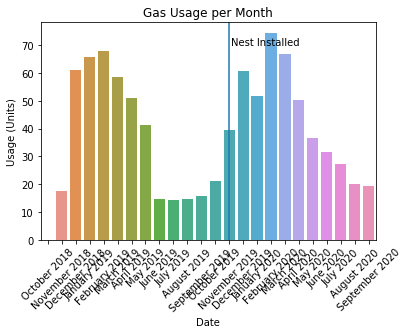

In [15]:
ax = sns.barplot(data=gas_df_reindexed, x=gas_df_reindexed.index, y=gas_df_reindexed['Monthly Usage'])
ax.set(ylabel='Usage (Units)', xlabel='Date')
plt.xticks(rotation=45)
plt.title('Gas Usage per Month')
plt.axvline(13)
plt.text(13.1,70,'Nest Installed')

We now have a good way of visualising the per month usage. Looking at the graph it appears that my usage has increased compared to previous years. One factor maybe the outside temperature, the colder it is the more the heating's used. We can see if we can predict the gas usage based on the average temperature for the month and then compare it to what was actually used. 

In [16]:
temperatures=pd.read_csv('./data/average_monthly_temperature.csv')

In [17]:
temperatures.head()

,Month,Average Temperature (C)
0,August 2020,19
1,July 2020,17
2,June 2020,16
3,May 2020,14
4,April 2020,11


In [18]:
temperatures.set_index('Month', inplace=True)

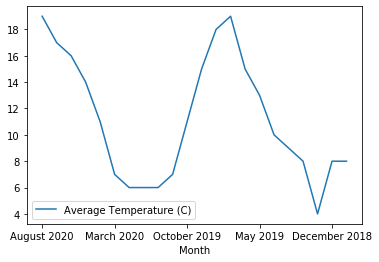

In [19]:
temperatures.plot()

Now we have some temperature data we can fit a regression to predict gas usage using past data. 

In [20]:
df = gas_df_reindexed
df['Average Temperature (C)'] = temperatures['Average Temperature (C)']
df.head()

,Gas Usage (Units),Monthly Usage,Average Temperature (C)
October 2018,2404.000000,NaN,NaN
November 2018,2421.692308,17.692308,8.0
December 2018,2482.723404,61.031097,8.0
January 2019,2548.514286,65.790881,4.0
February 2019,2616.600000,68.085714,8.0


In [21]:
train_data = df.loc['November 2018':'November 2019']
train_data

,Gas Usage (Units),Monthly Usage,Average Temperature (C)
November 2018,2421.692308,17.692308,8.0
December 2018,2482.723404,61.031097,8.0
January 2019,2548.514286,65.790881,4.0
February 2019,2616.600000,68.085714,8.0
March 2019,2675.000000,58.400000,9.0
April 2019,2726.092593,51.092593,10.0
May 2019,2767.333333,41.240741,13.0
June 2019,2782.095238,14.761905,15.0
July 2019,2796.380952,14.285714,19.0
August 2019,2811.058824,14.677871,18.0


In [22]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(train_data['Average Temperature (C)'].values.reshape(-1, 1), train_data['Monthly Usage'])
reg.score(train_data['Average Temperature (C)'].values.reshape(-1, 1), train_data['Monthly Usage'])

0.5587347217840505

In [23]:
predictions= reg.predict(df.loc['December 2018': 'August 2020']['Average Temperature (C)'].values.reshape(-1,1))


In [24]:
train_data

,Gas Usage (Units),Monthly Usage,Average Temperature (C)
November 2018,2421.692308,17.692308,8.0
December 2018,2482.723404,61.031097,8.0
January 2019,2548.514286,65.790881,4.0
February 2019,2616.600000,68.085714,8.0
March 2019,2675.000000,58.400000,9.0
April 2019,2726.092593,51.092593,10.0
May 2019,2767.333333,41.240741,13.0
June 2019,2782.095238,14.761905,15.0
July 2019,2796.380952,14.285714,19.0
August 2019,2811.058824,14.677871,18.0


In [25]:
test_data = df.loc['December 2018': 'August 2020']
test_data['Predicted'] = predictions
test_data.index = pd.to_datetime(test_data.index).strftime('%B %Y')
test_data

,Gas Usage (Units),Monthly Usage,Average Temperature (C),Predicted
December 2018,2482.723404,61.031097,8.0,48.487969
January 2019,2548.514286,65.790881,4.0,62.805564
February 2019,2616.600000,68.085714,8.0,48.487969
March 2019,2675.000000,58.400000,9.0,44.908570
April 2019,2726.092593,51.092593,10.0,41.329171
May 2019,2767.333333,41.240741,13.0,30.590974
June 2019,2782.095238,14.761905,15.0,23.432176
July 2019,2796.380952,14.285714,19.0,9.114580
August 2019,2811.058824,14.677871,18.0,12.693979
September 2019,2826.925926,15.867102,15.0,23.432176


Text(0.5, 1.0, 'Predicted vs Actual Gas Usage after Nest Installation')

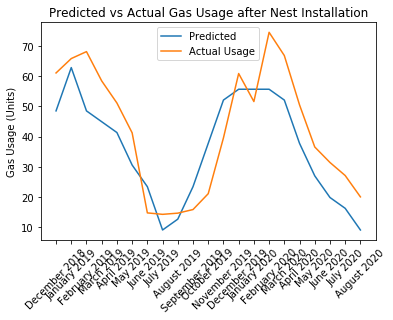

In [26]:
plt.plot(test_data.Predicted)
plt.plot(test_data['Monthly Usage'])
plt.legend(('Predicted', 'Actual Usage'))
plt.ylabel('Gas Usage (Units)')
plt.xticks(rotation=45)
plt.title('Predicted vs Actual Gas Usage after Nest Installation')

Overall you can see that the predcictions roughly mirrors the overall trend, but offers no evidence to support the hypothesis that the Nest thermostat has reduce my gas usage. However, that doesn't mean to say that it hasn't. Ideally much more granular data would be needed to make th conclusion. Ideally, day by data meter reading, day by day average temperatures along with the times that the house isn't occupied. Analsis like the one above will never be able to take into account changing patterns of life, such as holidays etc. and a lot more data would be needed to make any statistically sound conclusions.